## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [63]:
%pip install yfinance
%pip install datareader
%pip install statsmodels


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [64]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [65]:
df =yf.download("005930.KS", "2019-01-01") # 끝을 설정하지 않으면 최근까지 출력
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,39400.0,39400.0,38550.0,38750.0,33474.054688,7847664
2019-01-03,38300.0,38550.0,37450.0,37600.0,32480.625000,12471493
2019-01-04,37450.0,37600.0,36850.0,37450.0,32351.056641,14108958
2019-01-07,38000.0,38900.0,37800.0,38750.0,33474.054688,12748997
2019-01-08,38000.0,39200.0,37950.0,38100.0,32912.558594,12756554
...,...,...,...,...,...,...
2024-09-30,64200.0,64300.0,61500.0,61500.0,61500.000000,32694163
2024-10-02,60500.0,61900.0,59900.0,61300.0,61300.000000,28473536
2024-10-04,61000.0,61700.0,60500.0,60600.0,60600.000000,24247578


1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [66]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [67]:
df.index.name = 'Date'
df = df.sort_index(ascending=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,39400.0,39400.0,38550.0,38750.0,33474.054688,7847664
2019-01-03,38300.0,38550.0,37450.0,37600.0,32480.625000,12471493
2019-01-04,37450.0,37600.0,36850.0,37450.0,32351.056641,14108958
2019-01-07,38000.0,38900.0,37800.0,38750.0,33474.054688,12748997
2019-01-08,38000.0,39200.0,37950.0,38100.0,32912.558594,12756554
...,...,...,...,...,...,...
2024-09-30,64200.0,64300.0,61500.0,61500.0,61500.000000,32694163
2024-10-02,60500.0,61900.0,59900.0,61300.0,61300.000000,28473536
2024-10-04,61000.0,61700.0,60500.0,60600.0,60600.000000,24247578


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

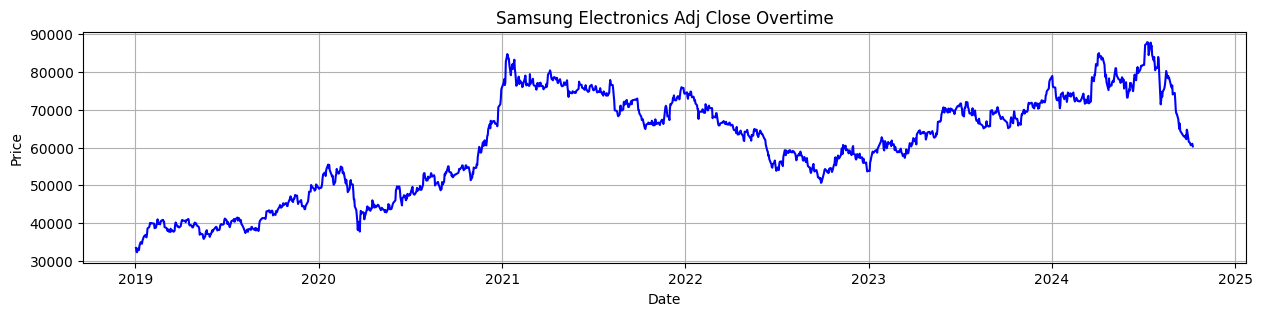

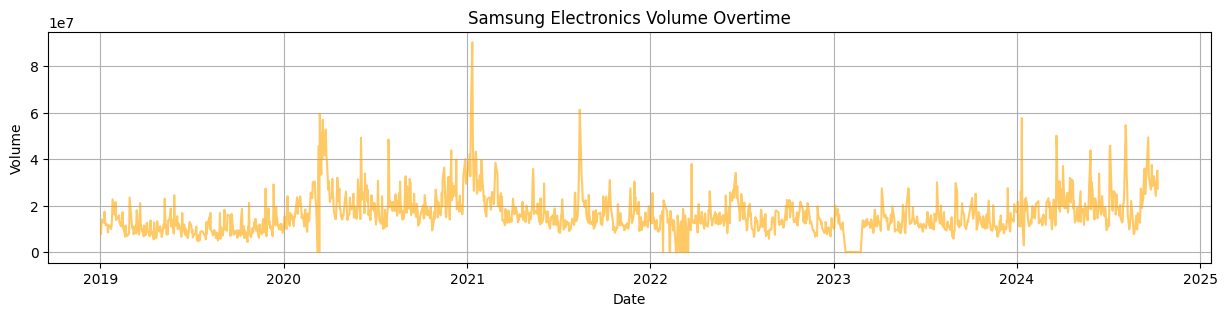

In [68]:
# Adj Close
plt.figure(figsize=(15, 3))
plt.plot(df.index, df['Adj Close'], color='blue')
plt.title("Samsung Electronics Adj Close Overtime")
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Volume
plt.figure(figsize=(15, 3))
plt.plot(df.index, df['Volume'], color='orange', alpha=0.6)
plt.title("Samsung Electronics Volume Overtime")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

- 2020년 초부터 삼성전자의 수정 종가는 크게 상승하여 2021년 초에 최고점을 찍었다.
- 이후 2021년 중반부터 2022년 말까지 하락세를 겪었으며, 2023년에도 등락이 반복되고 있지만 2020년의 가격 수준보다는 높은 위치에 있다.
- 2020년 초에는 거래량이 상대적으로 적었으나, 2021년 초반에 거래량이 급격히 상승하는 것을 확인할 수 있다.

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

`정상성`이란 시점에 상관없이 시계열의 특성이 일정하다는 것을 의미하며 조건은 다음과 같다
1. 평균이 일정하다 (시점 t에 의존X)
2. 분산 $Var(Z_t)$도 시점 t에 의존하지 않는다
3. 공분산 $Cov(Z_t,Z_s)$는 단지 시차 t-s에만 의존하고 실제 시점들인 t와 s에는 의존하지 않는다

정상성을 가정해야만 시간에 따라 데이터의 통계적 특성이 일관되며, 모델을 효과적으로 사용할 수 있다 
<br><br>
비정상성을 해결하기 위해
- 로그변환
- 차분
- 계절성 제거 <br>
등을 진행할 수 있다

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [69]:
from statsmodels.tsa.stattools import adfuller

In [70]:
def adf_test(y):
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# of Lags Used', '# of Observations Used']) # # of Lags Used:사용된 시차 수, # of Observations Used: 사용된 관측치 수
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)

In [71]:
adf_test(df['Adj Close'].dropna())

Results of Augmented Dickey-Fuller test:
Test Statistic              -2.211154
p-value                      0.202222
# of Lags Used               2.000000
# of Observations Used    1415.000000
Critical Value (1%)         -3.434980
Critical Value (5%)         -2.863585
Critical Value (10%)        -2.567859
dtype: float64


2.3 ADF Test 결과를 해석하세요.

- ADF 테스트의 귀무가설($H_0$)은 '정상성을 만족하지 않는다'로 p-value가 0.05보다 크므로 귀무가설을 기각할 수 없다. 따라서 데이터가 비정상성을 가진다고 할 수 있다.
- ADF 테스트에서 중요한 것은 Test Statistic이 각 임계값보다 더 작은지 여부이다 <br>
현재 Test Statistic이 -2.210692로, 1%, 5%, 10% 임계값 중 어느 것보다도 작지 않다. 즉, 어느 수준에서도 귀무가설을 기각할 수 없다는 의미를 가진다

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

ACF(자기상관 함수, Autocorrelation Function)와 PACF(부분 자기상관 함수, Partial Autocorrelation Function)는 현재의 값이 과거의 값과 어떤 관계를 갖고 있는지 보여주는 plot으로

- ACF는 k시간 단위로 구분된 시계열의 관측치 간 상관계수 함수로 k가 커질수록 ACF는 0에 가까워진다 <br>
이동평균(Moving Average, MA) 모델의 적합한 차수를 결정하는 데 유용하다
- PACF는 시차 k에서의 k단계만큼 떨어져 있는 모든 데이터 점들 간의 순수한 상관관계를 의미한다 <br>
자기회귀(AutoRegressive, AR) 모델의 적합한 차수를 결정하는 데 유용하다

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

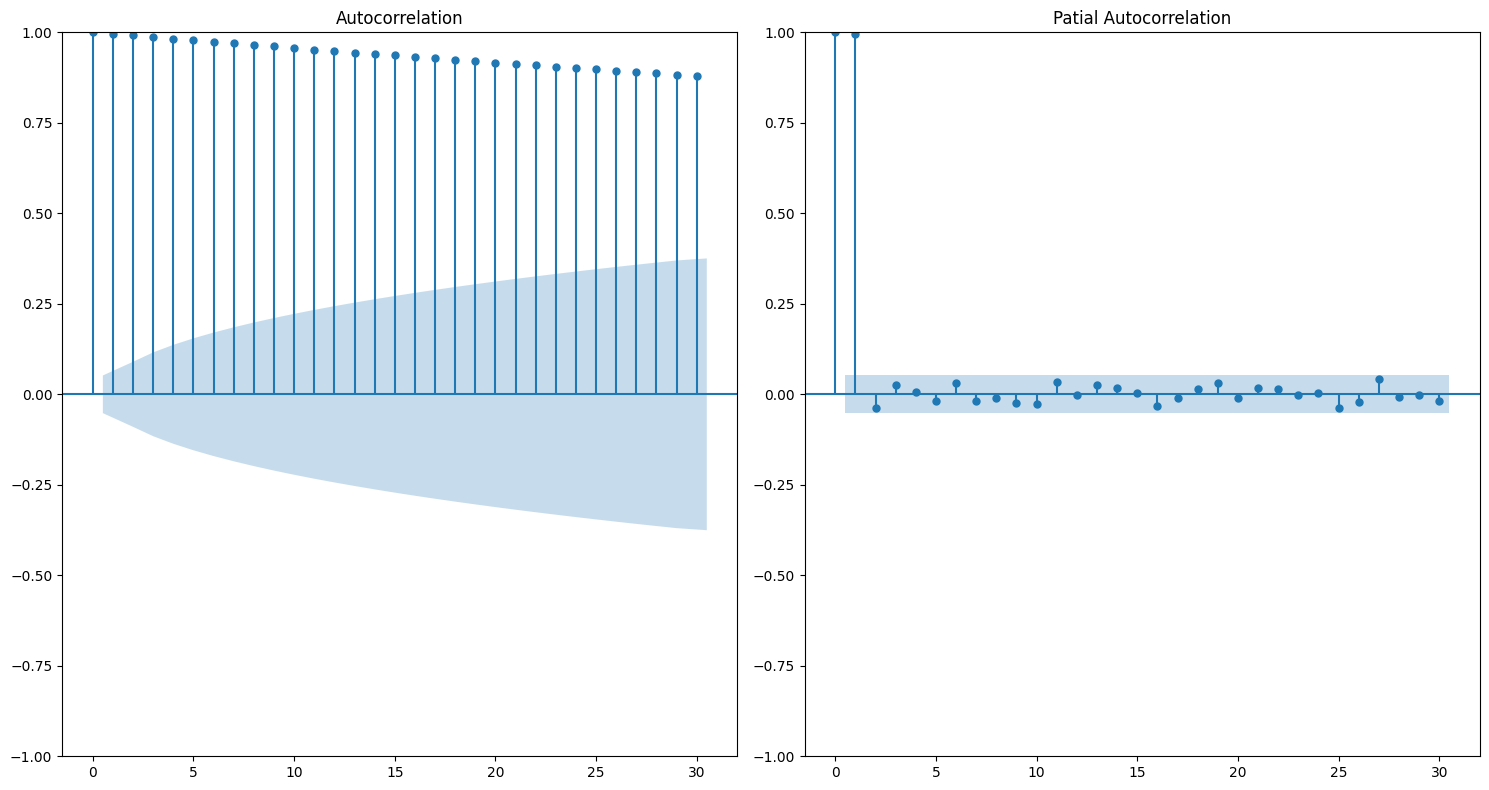

In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 8))

# ACF
plt.subplot(1, 2, 1)
plot_acf(df['Adj Close'], lags=30, ax=plt.gca())
plt.title('Autocorrelation')

# PACF
plt.subplot(1, 2, 2)
plot_pacf(df['Adj Close'], lags=30, ax=plt.gca())
plt.title('Patial Autocorrelation')

plt.tight_layout()
plt.show()

2.6 결과를 해석하세요.

ACF는 모든 시차에서 높은 상관관계를 보이며 이는 시계열 데이터가 비정상성을 띠고 있다는 것을 뜻한다. <br>
PACF는 시차 1 이후 급격히 상관관계가 감소하는 것을 볼 수 있기에 AR(1) 모델이 적절함을 알 수 있다.

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

<Figure size 1200x800 with 0 Axes>

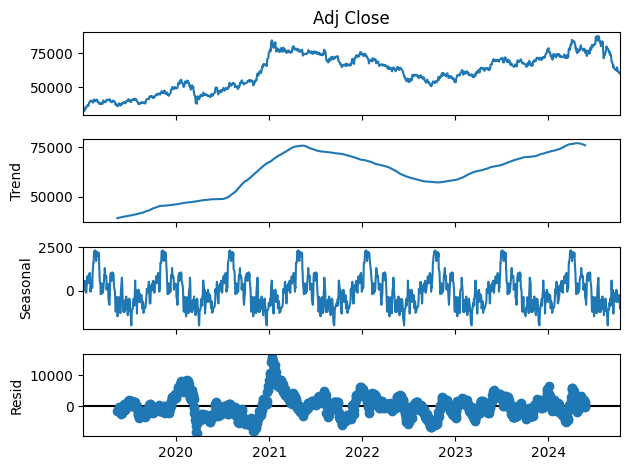

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose
# 계절성 분해
result = seasonal_decompose(df['Adj Close'], model='additive', period=180)

plt.figure(figsize=(12, 8))
result.plot()
plt.show()

# model = 'additice': 가법 모델을 사용 - 데이터가 추세, 계절성, 잔차가 더해져 완성된다고 가정
# period=180: 6개월(180일) 주기의 계절성을 분석

2.8 위 결과를 해석하세요.

- *Observed (Adj Close):* 실제 삼성전자 주가의 변화로 2020년부터 크게 상승하였고 이후 등락을 반복함을 볼 수 있다.
- *Trend:* 데이터의 장기적인 경향을 나타내는 그래프로 2020년부터 주가가 상승하다가 2021년 말부터 완만하게 하락하는 모습을 볼 수 있다.
- *Seasonal:* 데이터의 주기적인 패턴을 나타내는 그래프로 6개월 단위로 반복되는 계절성을 설정하였기 때문에 6개월마다 주기적인 변동이 있다.
- *Residual:* 추세와 계절성을 제거한 후 남은 불규칙한 변동을 나타내는 그래프로 비정상적인 요소나 노이즈를 포함한다. 여기서는 2020년 2021년 다소 큰 변동성을 보이지만 이후 안정화된 모습을 볼 수 있다.

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

- 차분은 시계열의 수준에서 나타나는 변화를 제거하여 시계열의 평균 변화를 일정하게 만드는 데 도움이 된다. 결과적으로 추세나 계절성이 제거(또는 감소)된다.

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [74]:
df_diff = df['Adj Close'].diff().dropna()

adf_result_diff = adfuller(df_diff)

adf_statistic_diff = adf_result_diff[0]
p_value_diff = adf_result_diff[1]

print(f"ADF Statistic (Differenced): {adf_statistic_diff}")
print(f"p-value (Differenced): {p_value_diff}")

ADF Statistic (Differenced): -27.391525040358644
p-value (Differenced): 0.0


2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

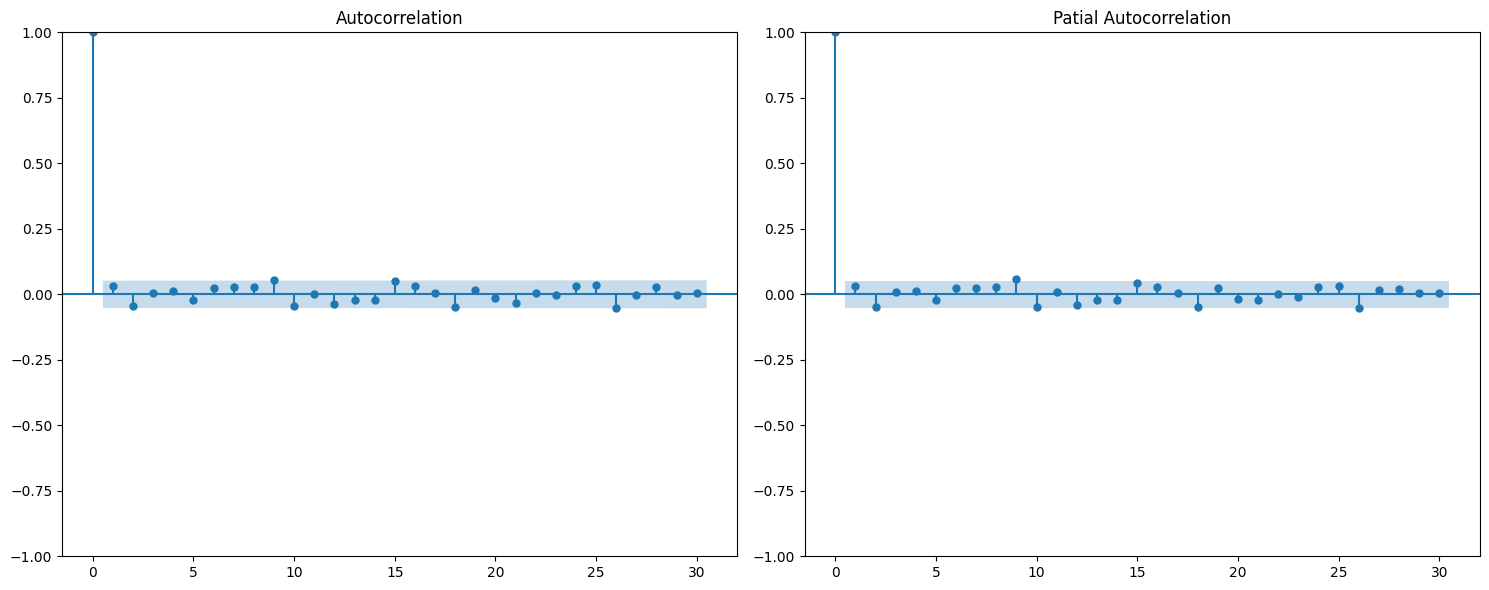

In [75]:
plt.figure(figsize=(15, 6))

# ACF
plt.subplot(1, 2, 1)
plot_acf(df_diff, lags=30, ax=plt.gca())
plt.title('Autocorrelation')

# PACF
plt.subplot(1, 2, 2)
plot_pacf(df_diff, lags=30, ax=plt.gca())
plt.title('Patial Autocorrelation')

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

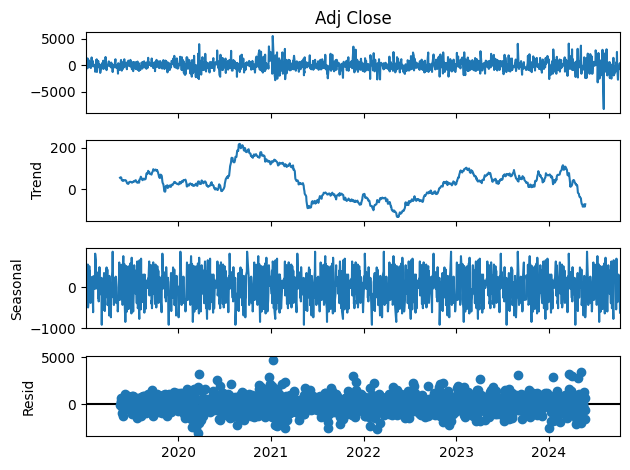

In [76]:
# 계절성 분해
result = seasonal_decompose(df_diff, model='additive', period=180)

plt.figure(figsize=(12, 8))
result.plot()
plt.show()

# model = 'additice': 가법 모델을 사용 - 데이터가 추세, 계절성, 잔차가 더해져 완성된다고 가정
# period=180: 6개월(180일) 주기의 계절성을 분석

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

### - LSTM

In [77]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [78]:
ticker = 'GOOGL'
df_ls = yf.download(ticker, start='2019-01-01', end='2024-01-01')
df_close = df_ls[['Close']] # 종가 데이터만 사용

[*********************100%***********************]  1 of 1 completed


In [79]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_close)

# 시퀀스 생성 함수
def create_sequences(data, seq_length):
    X,y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

In [80]:
SEQ_LENGTH = 80  # 80일간의 데이터를 사용하여 예측

X, y = create_sequences(scaled_data, SEQ_LENGTH)

# LSTM 입력을 위한 차원 조정
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [81]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [82]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [83]:
# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0785
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0068
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0045
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0045
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0041
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0039
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0035
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0035
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0033
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0029


In [84]:
# 예측
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


In [85]:
# 2024-01-01 이후의 실제 데이터 가져오기
df_future = yf.download(ticker, start='2024-01-01', end='2024-10-07')
actual_prices = df_future[['Close']].values

[*********************100%***********************]  1 of 1 completed


In [86]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 115.29472597008301
MAE: 114.46220602929459


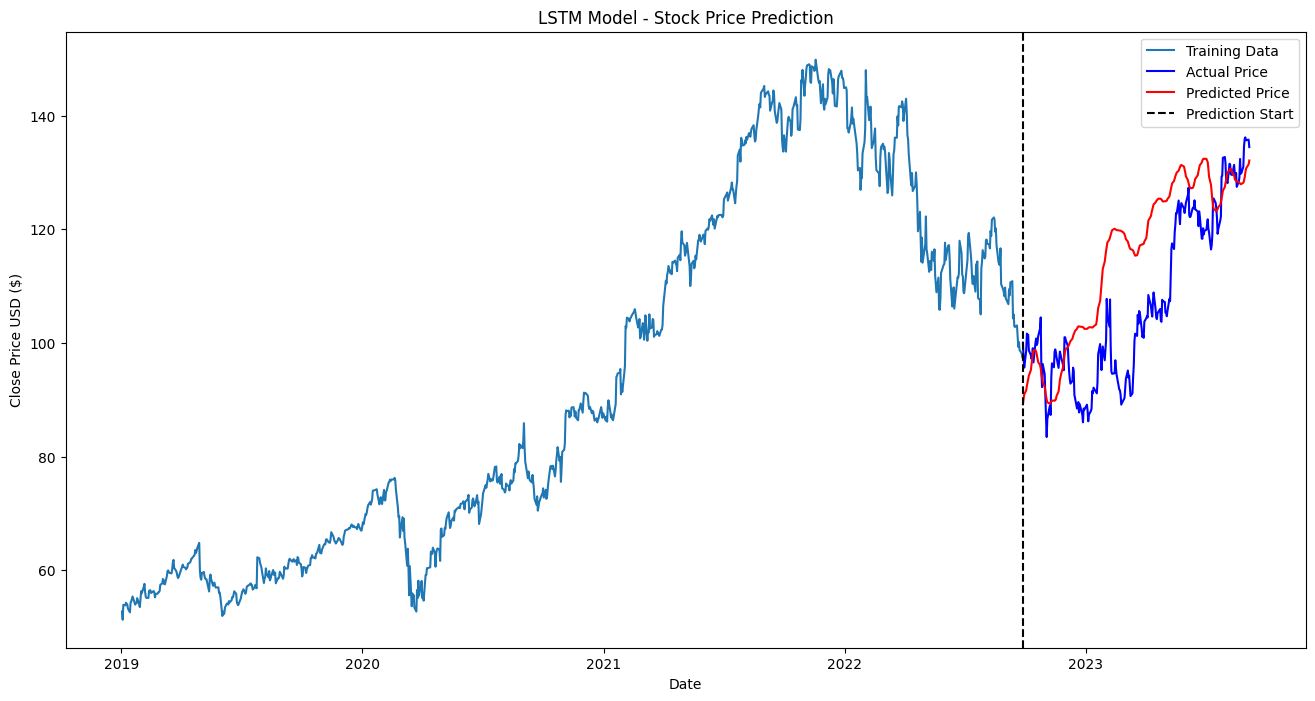

In [87]:
# 11. 예측 결과 시각화
train = df_close[:split]
valid = df_close[split:]

# valid 데이터프레임의 인덱스를 예측값의 길이에 맞추기 위해 조정
valid = valid.iloc[:len(predictions)]  # predictions와 동일한 길이로 valid 자르기
valid['Predictions'] = predictions

# 시각화
plt.figure(figsize=(16,8))
plt.title('LSTM Model - Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'], label='Training Data')
plt.plot(valid['Close'], label='Actual Price', color='blue')
plt.plot(valid['Predictions'], label='Predicted Price', color='red')
plt.axvline(x=valid.index[0], color='black', linestyle='--', label='Prediction Start')
plt.legend(loc='best')
plt.show()

### - Prophet

Prophet 모델이란?
https://wikidocs.net/233162

In [88]:
%pip install prophet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [89]:
from prophet import Prophet

In [90]:
###Prophet의 경우 ARIMA와 검정 및 전처리 과정이 약간 달라 새로 진행하였으며 보다 정확한 추세 예측을 위해 200일까지 예측하였습니다.###


ticker = 'GOOGL'
data = yf.download(ticker, start='2019-01-01', end='2024-01-01')

df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']  #Prophet에서는 날짜 컬럼을 'ds', 값 컬럼을 'y'로 설정해야 함
df

[*********************100%***********************]  1 of 1 completed


,ds,y
0,2019-01-02,52.734001
1,2019-01-03,51.273499
2,2019-01-04,53.903500
3,2019-01-07,53.796001
4,2019-01-08,54.268501
...,...,...
1253,2023-12-22,141.490005
1254,2023-12-26,141.520004
1255,2023-12-27,140.369995
1256,2023-12-28,140.229996


In [91]:
#모델 설정(파라미터는 따로 설정하지 않고 진행했으나 보다 정확한 예측을 위해 수정하는 것도 좋음)
model = Prophet()
model.fit(df)

21:07:31 - cmdstanpy - INFO - Chain [1] start processing
21:07:32 - cmdstanpy - INFO - Chain [1] done processing


In [92]:
#200일간의 예측 진행
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)

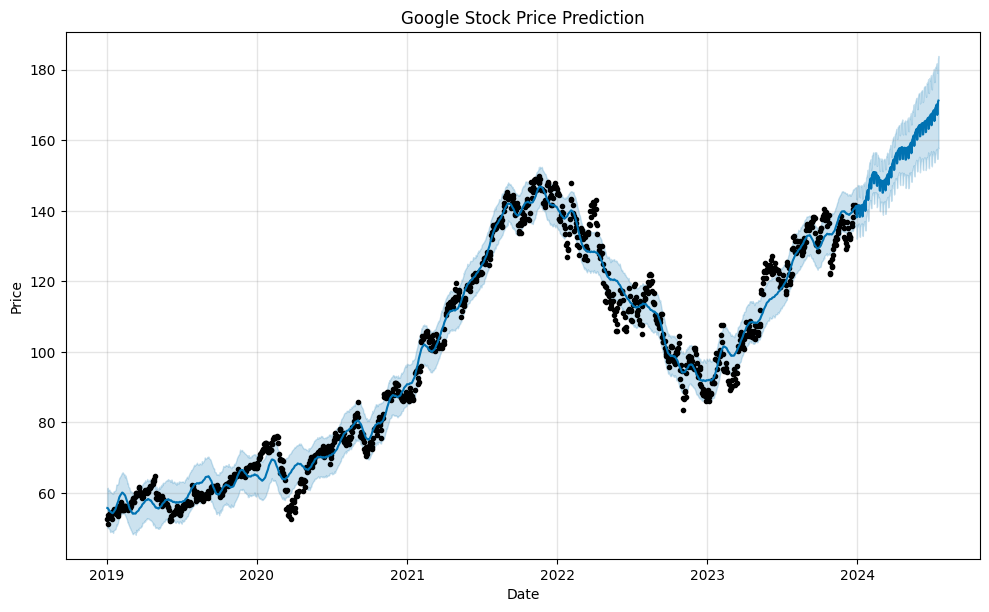

In [93]:
# 예측 결과 시각화
fig1 = model.plot(forecast)
plt.title('Google Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

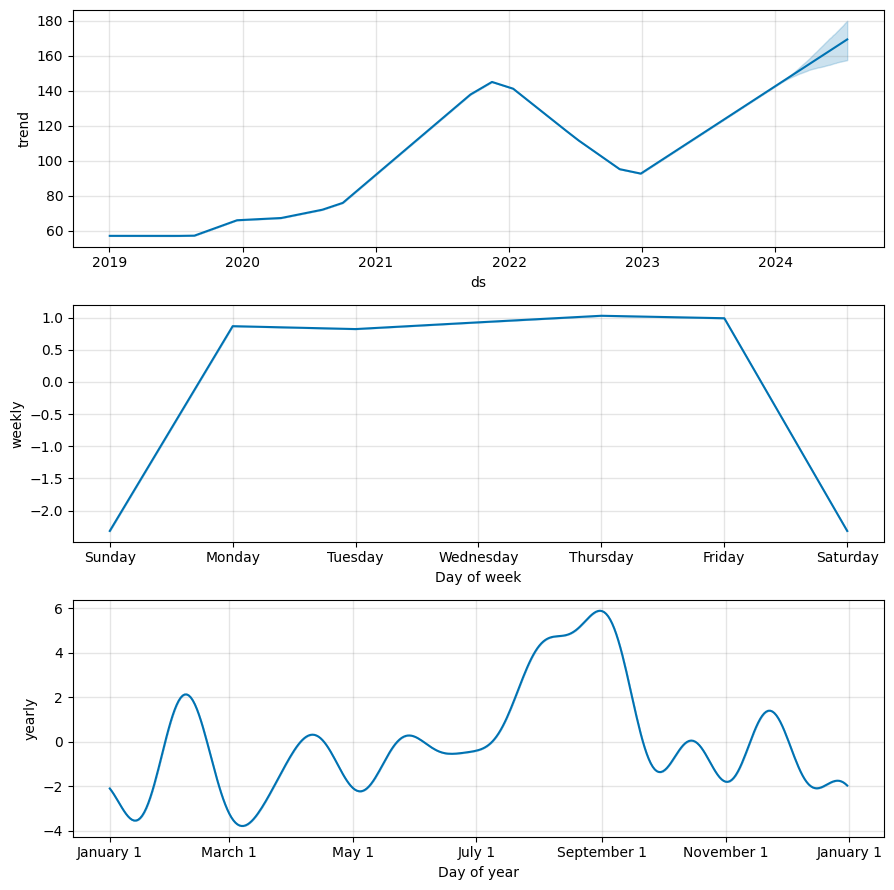

In [94]:
#트렌드 및 주기성 시각화
fig2 = model.plot_components(forecast)
plt.show()

In [95]:
#마지막 200일의 실제 주가 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-08-01')
actual_last_50 = actual_data_last_50.reset_index()[['Date', 'Close']]
actual_last_50.columns = ['ds', 'y']

[*********************100%***********************]  1 of 1 completed


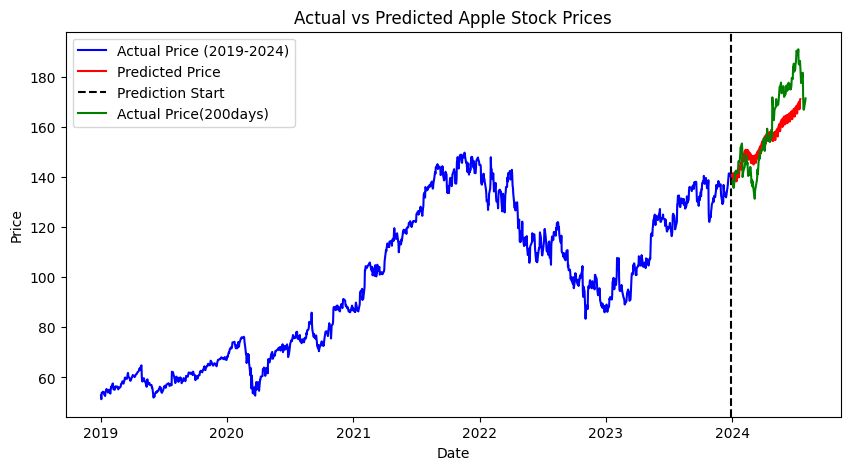

In [96]:
#실제 값과 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual Price (2019-2024)', color='blue')

plt.plot(forecast['ds'][len(df):], forecast['yhat'][len(df):], label='Predicted Price', color='red') ##전체 예측값 중 200일 이후 것만 사용
plt.axvline(x=df['ds'].iloc[-1], color='black', linestyle='--', label='Prediction Start')
plt.plot(actual_last_50['ds'], actual_last_50['y'], label='Actual Price(200days)', color='green')
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [97]:
# 실제값과 예측값
y_true = actual_last_50['y'].values
y_pred = forecast['yhat'].values[-len(y_true):]

# 성능 지표 계산
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 11.492671051831326
MAE: 9.562909871798327


예시에서는 전통적 시계열 모형인 ARIMA 보다 최신 기법인 Prophet이 보다 좋은 성능을 보였습니다. 

사실 ARIMA로도 좋은 예측을 진행할 수는 있으나 조금 간단하게 진행하였으며(죄송합니다..시간관계상 ㅠ) SARIMA, ARIMAX와 같이 발전된 모형을 사용하는 것도 방법입니다. 

예시보다 좋은 예측을 진행하여 주시길 바라며 단순히 시각화하는 것을 넘어서 ***RMSE***나 ***MAE***와 같은 성능지표를 활용해 정량적 평가를 진행해주시면 좋을 것 같습니다.